# <u> Stock Prediction using RNN</u>

It is not possible to predict stock price, but it's posible to predict the trend.
<br>

Here we will train the LSTM model with google stock price trend from 2012 to 2016 & try to predict the trend in first month of 2017.

## Data Preprocessing

### Import Libraries

In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [26]:
%matplotlib inline

### Import Training Set

In [57]:
train_df = pd.read_csv('.\data & solution\Google_Stock_Price_Train.csv', parse_dates=['Date'])

#train_df = pd.read_csv('.\data & solution\Google_Stock_Price_Train.csv', parse_dates=['Date'], index_col= ['Date'])
'''
no data values using the parameter  = na_values
date column using the parameter =  parse_dates
datetime index using the parameter = index_col
'''

# Select the important columns & Convert the dataset/dataframe to a numpy array which can be fed to the neural network.
training_set = train_df.iloc[:, 1:2].values

In [53]:
train_df.head(3)

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"


We will predict the open stock price (at what price stock opens)

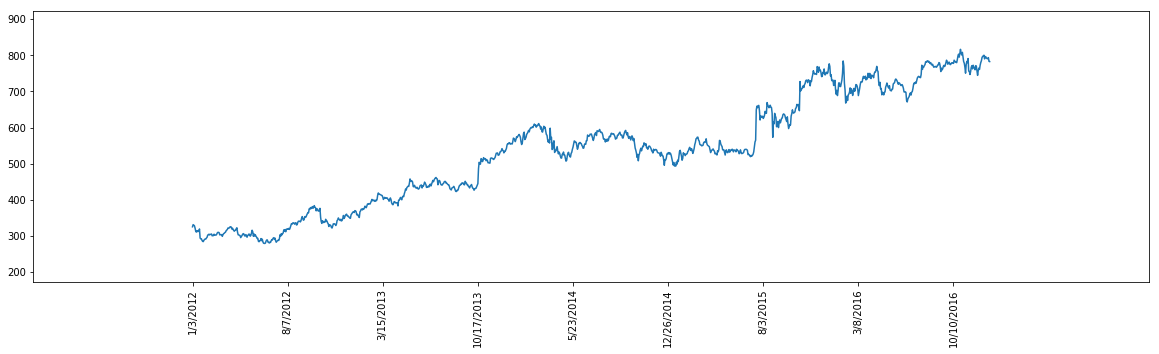

In [51]:
plt.figure(figsize=(20,5))

# Lets look at trend in open price
plt.plot(train_df['Date'], train_df['Open'])


#labels 

# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(train_df['Date'][::150],  rotation='vertical')

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)

# Print only few dates on x-axis
axis = plt.gca()  # Get current axis
#axis.set_xticks(axis.get_xticks()[::30])


#plt.locator_params(axis='x', nbins=30)

plt.show()

In [33]:
train_df['Open'][1255]

793.7

### Feature Scaling

<b>Types of feature Scaling</b>
![featureScaling](featureScaling.png)
<br>
<b>Which one should u use?</b><br>
When you have a sigmoid activation function in the output layer of a RNN, its recommended to apply normalization.

In [58]:
from sklearn.preprocessing import MinMaxScaler

# Here we perform Normalisation feature scaling. Hence we use MinMaxScaler()

# define scaler
scaler = MinMaxScaler() 
# above is same as below
#scaler = MinMaxScaler(feature_range=(0,1) (default)) --> This is range of Xnorm (and its obvious bcoz demonimator will always be greater than numerator)

# Scale the data
training_set_scaled = scaler.fit_transform(training_set)  # fit() will get min & max values of stock price & apply normalisation formula


### Prepare input & output dataset

In [59]:
# Creating a data structure with 60 timesteps & 1 output
'''
60 timesteps imply 3 months (20 financial days in each month) -- (60 is given experimentally by tiral & error)
So basically, to predict stock price of each day we use data of previous 60 days.

This means for each financial day, x_train will contain 60 previous stock prices before that financial day & y_train will 
contain the stock price of the next financial day.
'''

# Initially we intialize them objects as an empty list
x_train = []
y_train = []

In [61]:
# Looping the dataset -- This is like creating a sliding window of size 60 & stride of 1.
for i in range(60,len(training_set_scaled)):
    x_train.append(training_set_scaled[i-60:i, 0])   
    y_train.append(training_set_scaled[i,0])
    
# Converting list to nupy array which will be used as input to Neural Network
x_train, y_train = np.array(x_train), np.array(y_train)   # x-train is 2D array & y-train is 

In [64]:
x_train.shape

(1198, 60)

In [65]:
# Reshaping - Used to add a dimension to the existing structure

# input to RNN is a 3D tensor with shape [batch, timesteps, feature]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))  # reshape(array_to_reshape, new_size)

'''
batch = x_train.shape[0] -> bcoz we have spilt the data & put them in set. (No. of stock prices)
timestep = x_train.shape[1] -> timestep is 60 here (we have considered previous 60 days to predict value for next day)
feature = 1 -> as here we are only considering the open google stock price and not on any other related features.
'''

'\nbatch = x_train.shape[0] -> bcoz we have spilt the data & put them in set. (No. of stock prices)\ntimestep = x_train.shape[1] -> timestep is 60 here (we have considered previous 60 days to predict value for next day)\nfeature = 1 -> as here we are only considering the open google stock price and not on any other related features.\n'

## Building the RNN

### Import keras lib & package

In [68]:
# Here we will build a stacked LSTM  with some Dropout regularization to avoid overfitting
from keras.models import Sequential     # To create a neural network object that has sequence of layers
from keras.layers import Dense, LSTM, Dropout    # Dense class to add the output layer in NN
                                                 # LSTM class to add the LSTM layers in NN
                                                 # Dropout class to add the dropout regularization in NN

### Initialise the RNN

In [69]:
regressor = Sequential()    # create an object of Sequential class to hold the NN.

# Here we are predicting continuous values (google stock price) & not classes. Hence, object is named as regressor & not classifier

In [77]:
# Add different layers to create a stacked LSTM

# Adding first LSTM layer with some dropout regularisation to avoid overfitting
regressor.add(LSTM(units = 50, return_sequences = True, input_shape= (x_train.shape[1], 1)) ) 
              # LSTM(no_of_units, return_sequences, input_shape )
"""
no_of_units = no. of lstm cells / memory units/ neurons u want to have in lstm layer.
return_sequences = we set to true bcoz we are building stacked lstm which will thus have multiple lstm layers.
                    So when u add another lstm layer, this param should be true. 
                    Only for the last lstm layer, it should be false (default)
input_shape = this will be a 3D shape [batch/observations, timesteps, feature/indicators] (x_train)
              But here we only have to specify the timesteps & indicators, bcoz the first one 'observations', 
              will automatically be taken into account.
              Specify only in 1st lstm layer. In other lstm layers it is automatically detected
              
Here, we need a high dimensionality model in each lstm layer, bcoz our prediction task in complex, hence we choose large no. of neurons.
"""  

# Adding dropout layer
regressor.add(Dropout(0.2)) # Dropout(rate)
'''
The Dropout layer randomly sets input units to 0 with a frequency of `rate` at each step during training time,
which helps prevent overfitting.
Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

It's recommended to drop 20% of the neurons. these 20% neurons will be ignored during each itteration of the training in front & back propogation.
'''              


"\nThe Dropout layer randomly sets input units to 0 with a frequency of `rate` at each step during training time,\nwhich helps prevent overfitting.\nInputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.\n\nIt's recommended to drop 20% of the neurons. these 20% neurons will be ignored during each itteration of the training in front & back propogation.\n"

In [78]:
# Adding 2nd LSTM layer with some dropout regularisation 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding 3rd LSTM layer with some dropout regularisation 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding 4th LSTM layer with some dropout regularisation 
regressor.add(LSTM(units = 50))  # return_sequences = False
regressor.add(Dropout(0.2))

In [79]:
# Adding output layer
regressor.add(Dense(1))

'''
This layer is fully connected to the 4th lstm layer. hence we use the Dense class.
We are predict a real value, hence output has only 1 dimension.
'''

'\nThis layer is fully connected to the 4th lstm layer. hence we use the Dense class.\nWe are predict a real value, hence output has only 1 dimension.\n'

### Compiling the model with a powerful optimizer & the right loss (here it will be mean squared error)

In [81]:
regressor.compile(optimizer='adam', loss='mean_squared_error')
# 'rmsprop' is recommended optimizer for Recurrent NN

### Fit the NN to our training set

In [82]:
regressor.fit(x_train,y_train, epochs=100, batch_size=32 )
'''
the model will be trained on batches of our observations i.e batches of stock prices going into the NN.
So instead of updating the weights, every stock price being forward propogated & then generating error that is backward
propogated into NN, we will do that in every 32 stock prices (rows of observation) by setting batch size as 32.
'''

Epoch 1/100
38/38 [==============================] - 7s 179ms/step - loss: 0.0563
Epoch 2/100
38/38 [==============================] - 6s 162ms/step - loss: 0.0083
Epoch 3/100
38/38 [==============================] - 6s 169ms/step - loss: 0.0078
Epoch 4/100
38/38 [==============================] - 6s 164ms/step - loss: 0.0055
Epoch 5/100
38/38 [==============================] - 7s 172ms/step - loss: 0.0059
Epoch 6/100
38/38 [==============================] - 7s 171ms/step - loss: 0.0052
Epoch 7/100
38/38 [==============================] - 6s 167ms/step - loss: 0.0050
Epoch 8/100
38/38 [==============================] - 7s 182ms/step - loss: 0.0049
Epoch 9/100
38/38 [==============================] - 7s 173ms/step - loss: 0.0048
Epoch 10/100
38/38 [==============================] - 6s 167ms/step - loss: 0.0044
Epoch 11/100
38/38 [==============================] - 6s 164ms/step - loss: 0.0046
Epoch 12/100
38/38 [==============================] - 6s 166ms/step - loss: 0.0048
Epoch 13/100


'\nthe model will be trained on batches of our observations i.e batches of stock prices going into the NN.\nSo instead of updating the weights, every stock price being forward propogated & then generating error that is backward\npropogated into NN, we will do that in every 32 stock prices (rows of observation) by setting batch size as 32.\n'

## Making Prediction & visualizing the result

### Getting Real Stock price of 2017

In [83]:
test_df = pd.read_csv('.\data & solution\Google_Stock_Price_Test.csv', parse_dates=['Date'])
real_stock_price = test_df.iloc[:, 1:2].values   # Read only column 'Open'

### Getting predicted stock price of 2017

In [96]:
# The model is expected to capture approx trend & not exact stock values
# To predict the stock price on 'T+1'th day, we need the stock price of previous 60 days.
# Since we are predicting stock prices of Jan 2017, we need both training & test set.
# We simply cannot concatenate the training & test set, bcoz then we will also have to perform scale transformation 
# & we should avoid such alterations to our test data

dataset_total = pd.concat((train_df['Open'], test_df['Open']), axis=0) # we concat the 2 dataset along vertical axis.

# Initially we have to predict stock value for 3rd Jan (1st financial day of the year 2017). 
# For this we need previous 60 financial days records.
# So index of 3rd Jan 2017 value = len(dataset_total)-len(test_df)
# inputs, a numpy array, consists of all values we require for trend analysis of Jan 2017
inputs = dataset_total[len(dataset_total)-len(test_df)-60:].values  # This will give 1D array/ list with all values

#print(inputs)
#print(inputs.shape)

In [101]:
# Reshapping the 1D numpy array in 2D format
inputs = inputs.reshape(-1,1)  # same as inputs.reshape((-1,1)) -> keep 1st dimension (no. of rows) as it is & set column as 1
#print(inputs)

In [102]:
# RNN was trained on scaled values, so now we scale the inputs. (We are not scaling test_df, we are scaling the inputs we get)
inputs = scaler.transform(inputs)

In [104]:
# Preparing the test data structure
x_test = []

for i in range(60, inputs.shape[0]):
    x_test.append(inputs[i-60:i,0])

x_test = np.array(x_test)   

In [105]:
# Reshapping the 2D numpy array to 3D numpy 
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [106]:
# Make Prediction
predicted_stock_price = regressor.predict(x_test)

# The pridiction was scaled. So now we unscale it
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

### Visualising the results

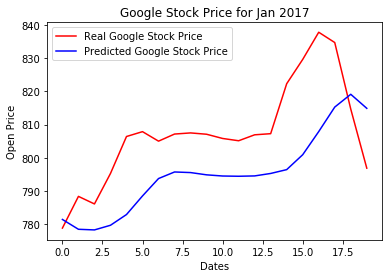

In [107]:
plt.plot(real_stock_price, color='red', label="Real Google Stock Price")
plt.plot(predicted_stock_price, color='blue', label="Predicted Google Stock Price")
plt.title("Google Stock Price for Jan 2017")
plt.xlabel('Dates')
plt.ylabel('Open Price')
plt.legend()
plt.show()

Based on visualization, in the parts of the prediction containing some spikes, our predictions lag behind the actual
values because our model cannot react to fast non-linear changes.
On the other hand, for the parts of the prediction containing smooth changes, the model reacted pretty well & manages to 
follow the upward,stable & downward trends.

In [109]:
'''
For Regression, the way to evaluate the model performance is with a metric called RMSE (Root Mean Squared Error). 
It is calculated as the root of the mean of the squared differences between the predictions and the real values.

However for our specific Stock Price Prediction problem, evaluating the model with the RMSE does not make much sense, 
since we are more interested in the directions taken by our predictions, rather than the closeness of their values to 
the real stock price. We want to check if our predictions follow the same directions as the real stock price and we 
don’t really care whether our predictions are close the real stock price. The predictions could indeed be close but 
often taking the opposite direction from the real stock price.
'''

# Check error:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print(rmse)

16.641549088187386


## Different ways to improve the RNN model:
<ol>
<li> <b>Getting more training data</b>: we trained our model on the past 5 years of the Google Stock Price but it would be even better to train it on the past 10 years. </li>
<li> <b>Increasing the number of timesteps</b>: the model remembered the stock prices from the 60 previous financial days to predict the stock price of the next day. That’s because we chose a number of 60 timesteps (3 months). You could try to increase the number of timesteps, by choosing for example 120 timesteps (6 months). </li>
<li> <b>Adding some other indicators</b>: if you have the financial instinct that the stock price of some other companies might be correlated to the one of Google, you could add this other stock price as a new indicator in the training data. </li>
<li> <b>Adding more LSTM layers</b>: we built a RNN with four LSTM layers but you could try with even more. </li>
<li> <b>Adding more neurones in the LSTM layers</b>: we highlighted the fact that we needed a high number of neurones in the LSTM layers to respond better to the complexity of the problem and we chose to include 50 neurones in each of our 4 LSTM layers. You could try an architecture with even more neurones in each of the 4 (or more) LSTM layers. </li>
</ol>